In [203]:
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,GRU
import pandas as pd
import matplotlib.pyplot as plt
#Submitted By Ashish Peruri

In [204]:


def preprocess(filepath,label):
    """
    Function to Preprocess the positive and negative labels
    """
    lineDict = {}
    f = open(label+".txt", "w")
    with open(filepath,"rt",encoding = "latin-1") as file:
        for line in file:
            newline = line
            newline = newline.lower()
            newline = re.sub("<.*?>", "",newline)         
            newline = re.sub("<[a-zA-Z]","",newline)     #Removing character after a single quote
            newline = re.sub("[a-zA-Z]>","",newline)     #Removing characters with a angular bracket following them
            newline = re.sub(r"[^\w]","",newline) 
            newline = re.sub(r"[^\x00-\x7f]","",newline) #Removing the non ascii characters
            newline = re.sub(r"[0-9]","",newline)         
            lineDict[newline] = label
            f.write(newline+"\n")         
    return lineDict

def preprocessOriginal(filepath,label):
    """
    Function for preprocessing the Original Data from the datasentences.txt
    """
    lineDict = {}
    f = open(label+".txt", "w")
    count = 0
    with open(filepath,'rt',encoding = 'latin-1') as file:
        for line in file:
            line = line.rstrip("\n")
            newline = line[2:]
            newline = newline.lower()
            newline = re.sub("<.*?>", "",newline)        #Removing HTML like Tags
            newline = re.sub("<[a-zA-Z]","",newline)     #Removing character after a single angular bracket
            newline = re.sub("[a-zA-Z]>","",newline)     #Removing characters with a angular bracket following them
            newline = re.sub(r"[^\w]","",newline) 
            newline = re.sub(r"[^\x00-\x7f]","",newline) #Removing the non ascii characters
            newline = re.sub(r"[0-9]","",newline) # removing numbers 
            cs = len(str(count))
            if count !=0:
                lineDict[newline] = [line[(1+cs):].strip(),count]
                f.write(newline+"\n") 
            count+=1
    return lineDict

In [205]:
def getEmbeddings(embeddingdimension):
    embeddingsDict = {}
    with open("glove.6B/glove.6B." + str(embeddingdimension) + "d.txt","rt",encoding="utf-8") as embeddingsFile:
        for line in embeddingsFile:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
#             coefs = np.asarray(values[1:], dtype='float32')
            embeddingsDict[word] = coefs
    embeddingsFile.close()
    return embeddingsDict

In [206]:
def embeddingFunc(vocabSize,word_index,wordvecDimension):
    wordEmbeddingMatrix = getEmbeddings(wordvecDimension)
    embedding_matrix = np.zeros((vocabSize, wordvecDimension))
    for word, i in word_index.items():
        embedding_vector = wordEmbeddingMatrix.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [207]:
def sentimentRNN(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(SimpleRNN(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model


def sentimentLSTM(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(LSTM(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model


def sentimentGRU(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(GRU(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

In [208]:
sentences = "original_rt_snippets.txt"
positive = "rt-polarity.pos"
negative = "rt-polarity.neg"
original = "datasetSentences.txt"

sentenceDict = preprocess(sentences,"unassigned")
positiveDict = preprocess(positive,"positive")
negativeDict = preprocess(negative,"negative")
origDict = preprocessOriginal(original,"original")


for sentence in sentenceDict:
    if sentence in positiveDict:
        sentenceDict[sentence] = "positive"
    elif sentence in negativeDict:
        sentenceDict[sentence] = "negative"

count = 0
for sentence in origDict:
    if sentence in sentenceDict:
        origDict[sentence].append(sentenceDict[sentence])
        count+=1


sentencesData = []  #Contains all the sentences
labelsData = []     #Contains labels for complete data
sentIndexDict = {}  #A dict mapping index and sentence used when data is split
labelsDataDict = {} #A dict mapping index and labels used when data is split for training purposes
dataFile = open("inputData.txt", "w") #Contains Preprocessed Data with labels attached

for sentence in origDict:
    if len(origDict[sentence]) == 3:
        dataFile.write(str(origDict[sentence][1]) + "  "+ origDict[sentence][0] +"   " + origDict[sentence][2] + "\n")
        line = origDict[sentence][0]
        index = int(origDict[sentence][1])
        line = line.strip()
        line = line.lower()
        line = line.translate(str.maketrans("", "", string.punctuation))
        if origDict[sentence][2] == "positive":
            labelsDataDict[index] = 1
            labelsData.append(1)
        else:
            labelsDataDict[index] = 0
            labelsData.append(0)
        sentencesData.append(line)
        
        sentIndexDict[index] = line


wholeData,trainData,devData,testData = [],[],[],[]        #contains train,dev,test data
wholeDataLabels, trainLabels,devLabels,testLabels = [],[],[],[]   #contains train,dev,test labels
wholeDataIndex,trainIndex,testIndex,devIndex = [],[],[],[]
with open("datasetSplit.txt", "r") as traindevtestFile:  #datasetSplit.txt contains data to divide train,dev,tets
    flag = True
    count = 0
    for line in traindevtestFile:
        if flag:
            flag = False
            continue
        count+=1
        index,temp = line.strip().split(",")
        index,temp =int(index),int(temp)
        if int(index) in sentIndexDict:
            words = [i for i in sentIndexDict[index].split(" ") if len(i)>1]
            wholeData.append(words)
            wholeDataIndex.append(int(index))
            wholeDataLabels.append(labelsDataDict[index])
            if temp == 1:
                trainIndex.append(int(index))
                trainLabels.append(labelsDataDict[index])
            elif temp == 2:
                testIndex.append(int(index))
                testLabels.append(labelsDataDict[index])
            else:
                devIndex.append(int(index))
                devLabels.append(labelsDataDict[index])


sequenceLength = 48 # defining sequence length of 60 #48
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wholeData)
sequences = tokenizer.texts_to_sequences(wholeData)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen = sequenceLength)
labels = wholeDataLabels


for i in range(len(data)):
    if wholeDataIndex[i] in trainIndex:
        trainData.append(data[i])
    elif wholeDataIndex[i] in testIndex:
        testData.append(data[i])
    else:
        devData.append(data[i])


vocabSize = len(word_index)+1
rnnModels = []
lstmModels = []
gruModels = []
sequneceLengths = [12,24,36,48]
#learningRates = [0.08,0.1,0.12,0.09]
learningRate = 0.03
hidden_layers = [12,18,24,36]
rnnModels = []
for i in range(4):
    rnnModels.append(sentimentRNN(vocabSize,word_index,300,learningRate,hidden_layers[i],sequenceLength))
#     lstmModels.append(sentimentRNN(vocabSize,word_index,300,learningRate,hidden_layers[i],sequenceLength))
#     gruModels.append(sentimentRNN(vocabSize,word_index,300,learningRate,hidden_layers[i],sequenceLength))
rnnhistories,lstmhistories,gruhistories = [],[],[]
for i in range(4):
    rnnhistories.append(rnnModels[i].fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(devData), np.asarray(devLabels))))
#     lstmhistories.append(lstmModels[i].fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(devData), np.asarray(devLabels))))
#     gruhistories.append(gruModels[i].fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(devData), np.asarray(devLabels))))






Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_223 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
simple_rnn_151 (SimpleRNN)   (None, 12)                3756      
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 13        
Total params: 5,277,169
Trainable params: 3,769
Non-trainable params: 5,273,400
_________________________________________________________________
None
Model: "sequential_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_224 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
simple_rnn_152 (SimpleRNN)   (None, 18)                5742      
_________

The plotting below is considering 5 Epochs
 For learning rate=12 SequenceLength = 48
 For learning rate=18 SequenceLength = 48
 For learning rate=24 SequenceLength = 48
 For learning rate=36 SequenceLength = 48


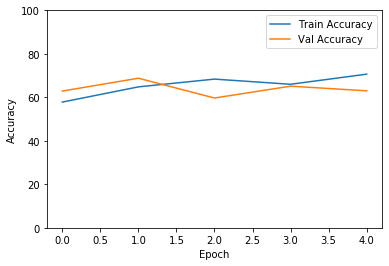

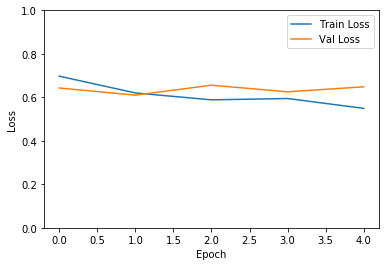

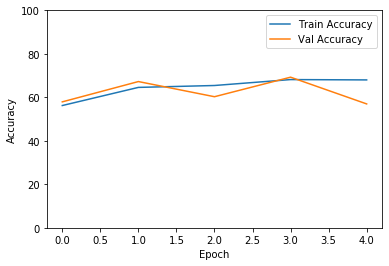

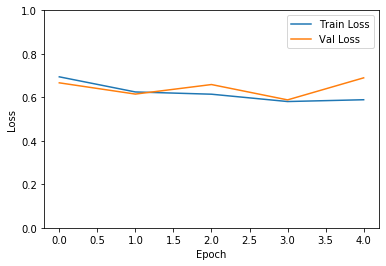

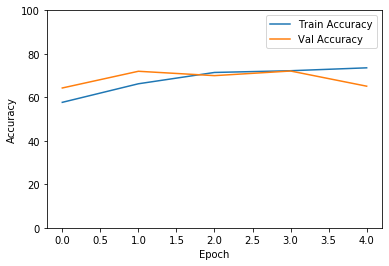

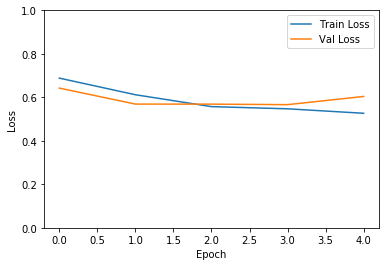

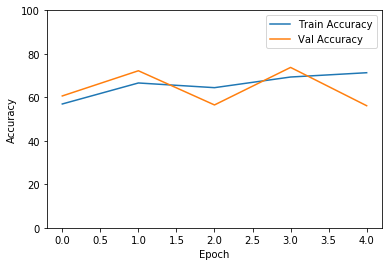

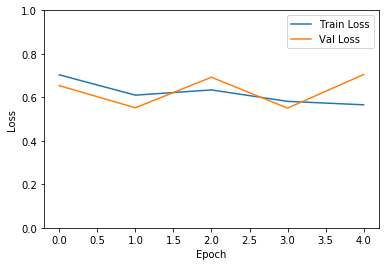

In [209]:
# A Function to plot the history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy']*100, label = 'Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy']*100, label = 'Val Accuracy')
    plt.ylim([0,100])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label = 'Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.ylim([0,1])
    plt.legend()
    

# Plotting the error and the accuracy for both training and validation data with epochs inorder to observe the data with best performance
print("The plotting below is considering 5 Epochs")
for i,h in enumerate(rnnhistories):
    print(" For learning rate"+"="+str(hidden_layers[i])+" SequenceLength = " + str(48))
    plot_history(h)

#### <font color = "green"> CV and Train Accuracies for plain RNN, LSTM, GRU </font>
#####For WordEmbedding Dimensions = 300

For <b>Plain RNN</b> We observe the best <b>cross validation accuracy = 72.93</b> and <b>training accuracy = 73.58</b> at <b>36 hidden layers</b> and sequence length 48

By checking various hyperparameters i.e hidden layers and sequence lengths I observed the highest accuracy at 36 hidden layers and sequence length 48

Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_227 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
simple_rnn_155 (SimpleRNN)   (None, 9)                 2790      
_________________________________________________________________
dense_226 (Dense)            (None, 1)                 10        
Total params: 5,276,200
Trainable params: 2,800
Non-trainable params: 5,273,400
_________________________________________________________________
None
Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_228 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
simple_rnn_156 (SimpleRNN)   (None, 18)                5742      
_________

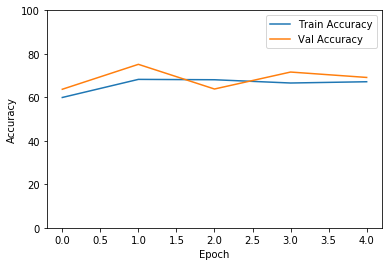

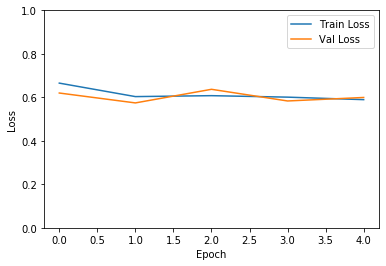

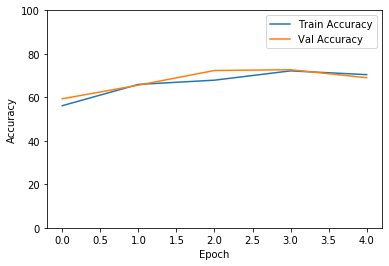

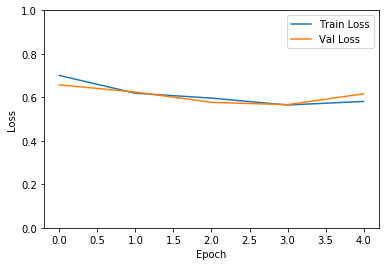

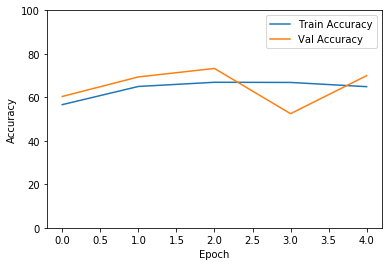

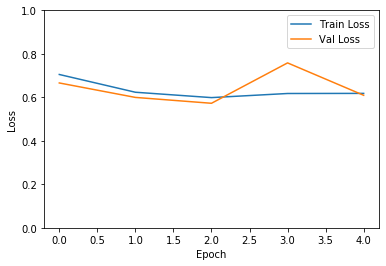

In [210]:
# Now I am considering both Half and double the Hidden Layers

rnnModelsUnitsChange = []
hiddenUnits = [9,18,36]
for i in range(3):
    rnnModelsUnitsChange.append(sentimentRNN(vocabSize,word_index,300,learningRate,hiddenUnits[i],48))
rnnHistoriesUnits = []
for model in rnnModelsUnitsChange:
    rnnHistoriesUnits.append(model.fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(devData), np.asarray(devLabels))))


# Plotting the error and the accuracy for both training and validation data with epochs inorder to observe the data with best performance

for i,h in enumerate(rnnHistoriesUnits):
    print(" For hidden units"+"="+str(hiddenUnits[i])+" SequenceLength = " + str(48))
    plot_history(h)



Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_230 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
lstm_36 (LSTM)               (None, 9)                 11160     
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 10        
Total params: 5,284,570
Trainable params: 11,170
Non-trainable params: 5,273,400
_________________________________________________________________
None
Model: "sequential_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_231 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
lstm_37 (LSTM)               (None, 18)                22968     
________

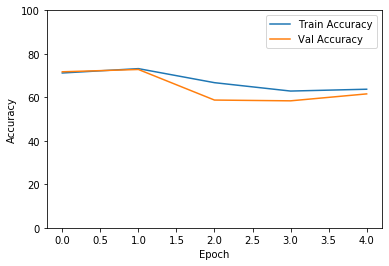

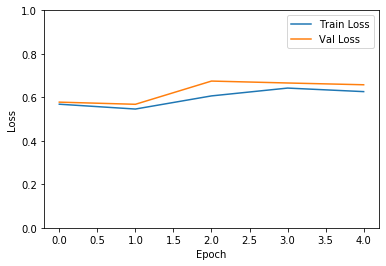

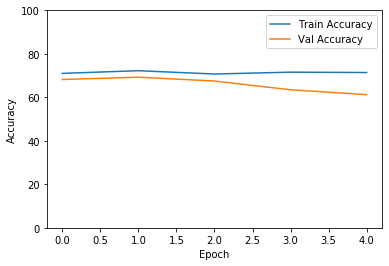

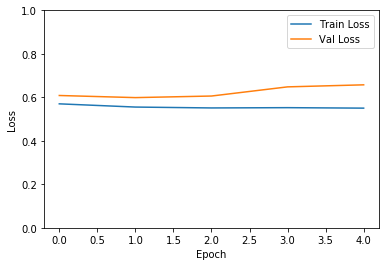

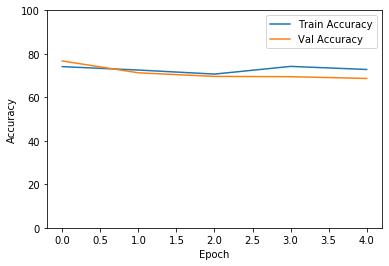

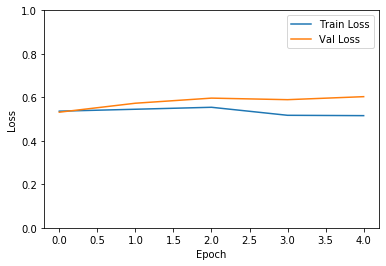

In [211]:
# Now I am considering both Half and double the Hidden Layers

lstmModelsUnitsChange = []
hiddenUnits = [9,18,36]
for i in range(3):
    lstmModelsUnitsChange.append(sentimentLSTM(vocabSize,word_index,300,learningRate,hiddenUnits[i],48))
lstmHistoriesUnits = []
for model in rnnModelsUnitsChange:
    lstmHistoriesUnits.append(model.fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(devData), np.asarray(devLabels))))


# Plotting the error and the accuracy for both training and validation data with epochs inorder to observe the data with best performance

for i,h in enumerate(lstmHistoriesUnits):
    print(" For hidden units"+"="+str(hiddenUnits[i])+" SequenceLength = " + str(48))
    plot_history(h)


In [212]:
# Now I am considering both Half and double the Hidden Layers

gruModelsUnitsChange = []
hiddenUnits = [9,18,36]
for i in range(3):
    gruModelsUnitsChange.append(sentimentRNN(vocabSize,word_index,300,learningRate,hiddenUnits[i],48))
gruHistoriesUnits = []
for model in gruModelsUnitsChange:
    gruHistoriesUnits.append(model.fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(devData), np.asarray(devLabels))))


# Plotting the error and the accuracy for both training and validation data with epochs inorder to observe the data with best performance

for i,h in enumerate(gruHistoriesUnits):
    print(" For hidden units"+"="+str(hiddenUnits[i])+" SequenceLength = " + str(48))
    plot_history(h)

Model: "sequential_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_233 (Embedding)    (None, 48, 300)           5273400   
_________________________________________________________________
simple_rnn_158 (SimpleRNN)   (None, 9)                 2790      
_________________________________________________________________
dense_232 (Dense)            (None, 1)                 10        
Total params: 5,276,200
Trainable params: 2,800
Non-trainable params: 5,273,400
_________________________________________________________________
None


KeyboardInterrupt: 

In [ ]:
#Here I am taking half the sequence length respencitively

newdata = pad_sequences(sequences,maxlen = 24)
labels = wholeDataLabels

newtrainData24,newtestData24,newdevData24 = [],[],[]
for i in range(len(newdata)):
    if wholeDataIndex[i] in trainIndex:
        newtrainData24.append(newdata[i])
    elif wholeDataIndex[i] in testIndex:
        newtestData24.append(newdata[i])
    else:
        newdevData24.append(newdata[i])

In [ ]:
rnn24model = sentimentRNN(vocabSize,word_index,300,learningRate,36,24)
hist = rnn24model.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newdevData24), np.asarray(devLabels)))
plot_history(hist)

In [ ]:
lstm24model = sentimentLSTM(vocabSize,word_index,300,learningRate,36,24)
hist = lstm24model.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newdevData24), np.asarray(devLabels)))
plot_history(hist)

Model: "sequential_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_206 (Embedding)    (None, 24, 300)           5273400   
_________________________________________________________________
gru_33 (GRU)                 (None, 36)                36504     
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 37        
Total params: 5,309,941
Trainable params: 36,541
Non-trainable params: 5,273,400
_________________________________________________________________
None
Train on 6534 samples, validate on 846 samples
Epoch 1/5
6534/6534 [==============================] - 5s 790us/sample - loss: 0.6267 - accuracy: 0.6602 - val_loss: 0.5080 - val_accuracy: 0.7600
Epoch 2/5
6534/6534 [==============================] - 2s 241us/sample - loss: 0.4502 - accuracy: 0.7876 - val_loss: 0.4558 - val_accuracy: 0.7967
Epoch 3/5
6534/6534 [

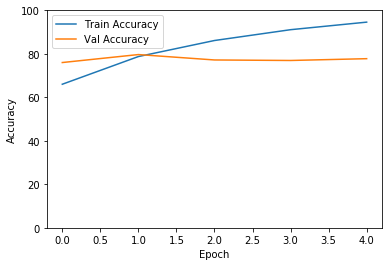

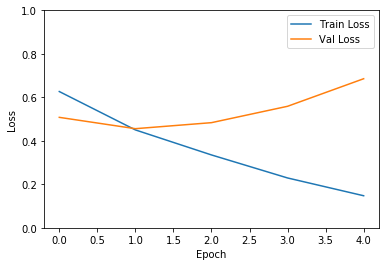

In [173]:
gru24model = sentimentGRU(vocabSize,word_index,300,learningRate,36,24)
hist = gru24model.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newdevData24), np.asarray(devLabels)))
plot_history(hist)

In [175]:
#Here I am taking double of the sequence length respencitively
newdata = pad_sequences(sequences, maxlen = 96)
labels = wholeDataLabels

newtrainData96,newtestData96,newdevData96 = [],[],[]
for i in range(len(newdata)):
    if wholeDataIndex[i] in trainIndex:
        newtrainData96.append(newdata[i])
    elif wholeDataIndex[i] in testIndex:
        newtestData96.append(newdata[i])
    else:
        newdevData96.append(newdata[i])

Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_207 (Embedding)    (None, 96, 300)           5273400   
_________________________________________________________________
simple_rnn_150 (SimpleRNN)   (None, 36)                12132     
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 37        
Total params: 5,285,569
Trainable params: 12,169
Non-trainable params: 5,273,400
_________________________________________________________________
None
Train on 6534 samples, validate on 846 samples
Epoch 1/5
6534/6534 [==============================] - 4s 674us/sample - loss: 0.7079 - accuracy: 0.5644 - val_loss: 0.6619 - val_accuracy: 0.6182
Epoch 2/5
6534/6534 [==============================] - 3s 514us/sample - loss: 0.6100 - accuracy: 0.6561 - val_loss: 0.5820 - val_accuracy: 0.7080
Epoch 3/5
6534/6534 [

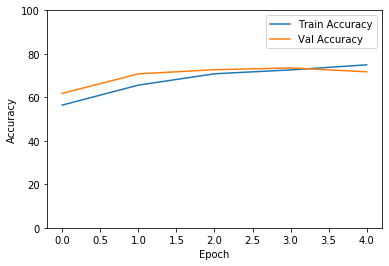

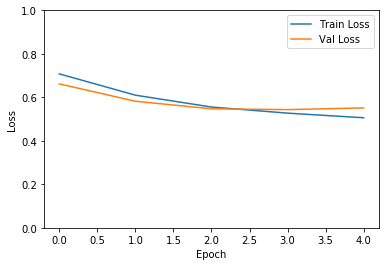

In [176]:
rnn96model = sentimentRNN(vocabSize,word_index,300,learningRate,36,96)
hist = rnn96model.fit(np.asarray(newtrainData96), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newdevData96), np.asarray(devLabels)))
plot_history(hist)

Model: "sequential_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_208 (Embedding)    (None, 96, 300)           5273400   
_________________________________________________________________
lstm_23 (LSTM)               (None, 36)                48528     
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 37        
Total params: 5,321,965
Trainable params: 48,565
Non-trainable params: 5,273,400
_________________________________________________________________
None
Train on 6534 samples, validate on 846 samples
Epoch 1/5
6534/6534 [==============================] - 10s 2ms/sample - loss: 0.7082 - accuracy: 0.5592 - val_loss: 0.6613 - val_accuracy: 0.6206
Epoch 2/5
6534/6534 [==============================] - 6s 881us/sample - loss: 0.5757 - accuracy: 0.7075 - val_loss: 0.5017 - val_accuracy: 0.7541
Epoch 3/5
6534/6534 [=

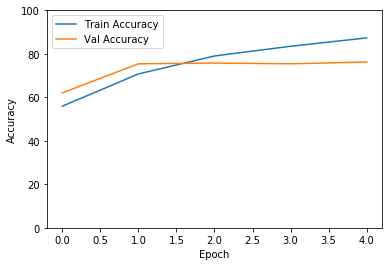

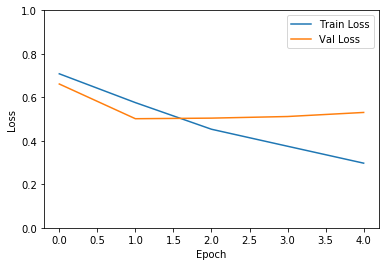

In [177]:
lstm96model = sentimentLSTM(vocabSize,word_index,300,learningRate,36,96)
hist = lstm96model.fit(np.asarray(newtrainData96), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newdevData96), np.asarray(devLabels)))
plot_history(hist)

Model: "sequential_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_210 (Embedding)    (None, 96, 300)           5273400   
_________________________________________________________________
gru_35 (GRU)                 (None, 36)                36504     
_________________________________________________________________
dense_209 (Dense)            (None, 1)                 37        
Total params: 5,309,941
Trainable params: 36,541
Non-trainable params: 5,273,400
_________________________________________________________________
None
Train on 6534 samples, validate on 846 samples
Epoch 1/5
6534/6534 [==============================] - 6s 913us/sample - loss: 0.2400 - accuracy: 0.9054 - val_loss: 0.5818 - val_accuracy: 0.7624
Epoch 2/5
6534/6534 [==============================] - 6s 959us/sample - loss: 0.1922 - accuracy: 0.9282 - val_loss: 0.6284 - val_accuracy: 0.7494
Epoch 3/5
6534/6534 [

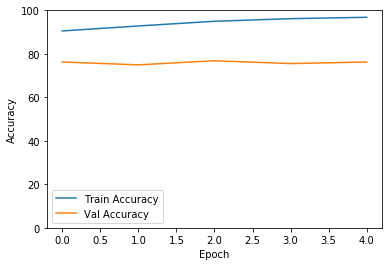

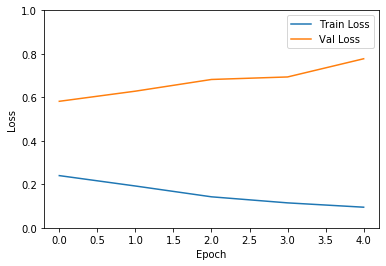

In [179]:
gru96model = sentimentGRU(vocabSize,word_index,300,learningRate,36,96)
hist = lstm96model.fit(np.asarray(newtrainData96), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newdevData96), np.asarray(devLabels)))
plot_history(hist)

### <font color = 'green'> Observations from Comparing models by changing Sequence Length and Hidden Units </font>
We observe that the accuracies of GRU,LSTM is a little better than the accuracy of the plain Vanilla RNN network.

When increasing the hidden unit size here I observe that the training accuracy increases by 3 percentage but the validation accuracy drops. This implies that increasing the hidden unit size is leading to overfitting in my case.
And also when we decrease the hidden unit we see that the accuracy drops in this case underfitting happens

When I am decreasing the sequnece length I observe that there is a visible change in training accuracy to more than 90 percentage and the validation accuracy to around 80 percentage. This can convey us that the first few words in the review are very important in determining the sentiment of a review. But again we see that the validation loss is increasing with the number of epochs. So its better if we can decrease the number of epochs. We observe that even when the training accuracy increases the validating accuracy remains almost unchanged. We cannot say whether the model is overfitted but it is not much better when 48 was taken as sequence length.


In [ ]:
####Best Models Occur at hidden units = 36 and sequence length = 24

In [ ]:
#Best RNN Model for word Embeddings of length 300
bestRNNModel = sentimentLSTM(vocabSize,word_index,300,learningRate,36,24)
bestRNNModel.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))

In [ ]:
#Best LSTM Model for word Embeddings of length 300
bestLSTMModel = sentimentLSTM(vocabSize,word_index,300,learningRate,36,24)
bestLSTMModel.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))

In [ ]:
#Best GRU Model for word Embeddings of length 300
bestGRUModel = sentimentLSTM(vocabSize,word_index,300,learningRate,36,24)
bestGRUModel.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))

In [ ]:
#RNN Model for word Embeddings of length 50
RNNModel50 = sentimentLSTM(vocabSize,word_index,50,learningRate,36,24)
hist = RNNModel50.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))
plot_history(hist)

Model: "sequential_220"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_218 (Embedding)    (None, 24, 50)            878900    
_________________________________________________________________
lstm_31 (LSTM)               (None, 36)                12528     
_________________________________________________________________
dense_217 (Dense)            (None, 1)                 37        
Total params: 891,465
Trainable params: 12,565
Non-trainable params: 878,900
_________________________________________________________________
None
Train on 6534 samples, validate on 1702 samples
Epoch 1/5
6534/6534 [==============================] - 4s 670us/sample - loss: 0.6649 - accuracy: 0.5986 - val_loss: 0.5920 - val_accuracy: 0.6957
Epoch 2/5
6534/6534 [==============================] - 1s 177us/sample - loss: 0.5510 - accuracy: 0.7107 - val_loss: 0.5513 - val_accuracy: 0.7180
Epoch 3/5
6534/6534 [===

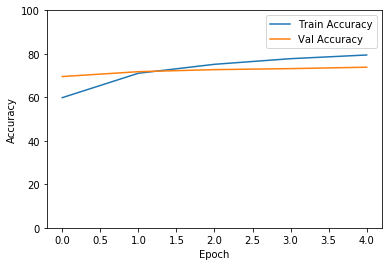

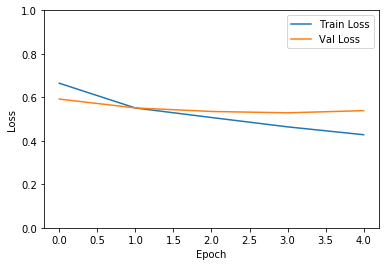

In [187]:
#LSTM Model for word Embeddings of length 50
LSTMModel50 = sentimentLSTM(vocabSize,word_index,50,learningRate,36,24)
hist = LSTMModel50.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))
plot_history(hist)

Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_219 (Embedding)    (None, 24, 50)            878900    
_________________________________________________________________
lstm_32 (LSTM)               (None, 36)                12528     
_________________________________________________________________
dense_218 (Dense)            (None, 1)                 37        
Total params: 891,465
Trainable params: 12,565
Non-trainable params: 878,900
_________________________________________________________________
None
Train on 6534 samples, validate on 1702 samples
Epoch 1/5
6534/6534 [==============================] - 5s 732us/sample - loss: 0.6530 - accuracy: 0.6244 - val_loss: 0.5657 - val_accuracy: 0.7015
Epoch 2/5
6534/6534 [==============================] - 1s 151us/sample - loss: 0.5467 - accuracy: 0.7224 - val_loss: 0.5536 - val_accuracy: 0.7004
Epoch 3/5
6534/6534 [===

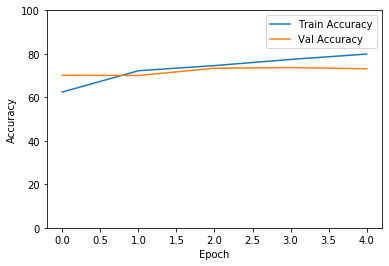

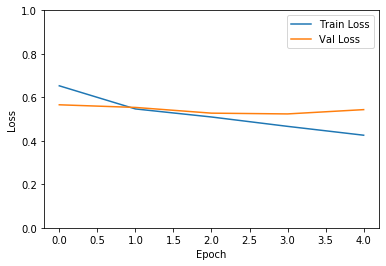

In [188]:
#GRU Model for word Embeddings of length 50
GRUModel50 = sentimentLSTM(vocabSize,word_index,50,learningRate,36,24)
hist = GRUModel50.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))
plot_history(hist)

Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_220 (Embedding)    (None, 24, 100)           1757800   
_________________________________________________________________
lstm_33 (LSTM)               (None, 36)                19728     
_________________________________________________________________
dense_219 (Dense)            (None, 1)                 37        
Total params: 1,777,565
Trainable params: 19,765
Non-trainable params: 1,757,800
_________________________________________________________________
None
Train on 6534 samples, validate on 1702 samples
Epoch 1/5
6534/6534 [==============================] - 19s 3ms/sample - loss: 0.6776 - accuracy: 0.6235 - val_loss: 0.5971 - val_accuracy: 0.7021
Epoch 2/5
6534/6534 [==============================] - 1s 176us/sample - loss: 0.5388 - accuracy: 0.7337 - val_loss: 0.5110 - val_accuracy: 0.7350
Epoch 3/5
6534/6534 [

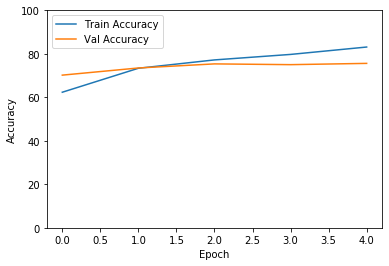

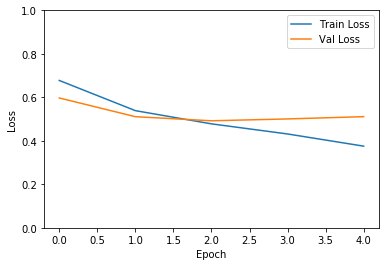

In [189]:
#RNN Model for word Embeddings of length 100
RNNModel100 = sentimentLSTM(vocabSize,word_index,100,learningRate,36,24)
hist = RNNModel100.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))
plot_history(hist)

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_221 (Embedding)    (None, 24, 50)            878900    
_________________________________________________________________
lstm_34 (LSTM)               (None, 36)                12528     
_________________________________________________________________
dense_220 (Dense)            (None, 1)                 37        
Total params: 891,465
Trainable params: 12,565
Non-trainable params: 878,900
_________________________________________________________________
None
Train on 6534 samples, validate on 1702 samples
Epoch 1/5
6534/6534 [==============================] - 5s 738us/sample - loss: 0.7049 - accuracy: 0.5601 - val_loss: 0.6587 - val_accuracy: 0.6246
Epoch 2/5
6534/6534 [==============================] - 1s 157us/sample - loss: 0.5923 - accuracy: 0.6954 - val_loss: 0.5548 - val_accuracy: 0.7203
Epoch 3/5
6534/6534 [===

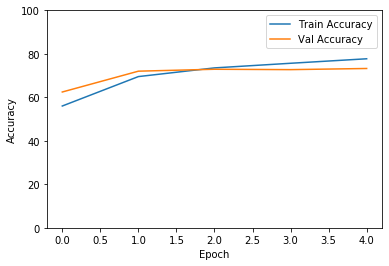

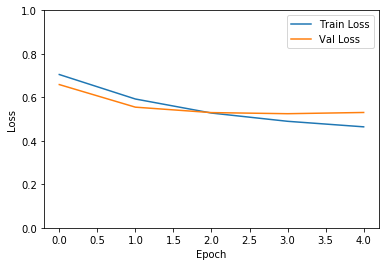

In [190]:
#LSTM Model for word Embeddings of length 100
LSTMModel100 = sentimentLSTM(vocabSize,word_index,50,learningRate,36,24)
hist = LSTMModel100.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))
plot_history(hist)

Model: "sequential_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_222 (Embedding)    (None, 24, 50)            878900    
_________________________________________________________________
lstm_35 (LSTM)               (None, 36)                12528     
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 37        
Total params: 891,465
Trainable params: 12,565
Non-trainable params: 878,900
_________________________________________________________________
None
Train on 6534 samples, validate on 1702 samples
Epoch 1/5
6534/6534 [==============================] - 4s 687us/sample - loss: 0.6887 - accuracy: 0.5843 - val_loss: 0.6423 - val_accuracy: 0.6340
Epoch 2/5
6534/6534 [==============================] - 1s 154us/sample - loss: 0.5752 - accuracy: 0.7011 - val_loss: 0.5558 - val_accuracy: 0.7197
Epoch 3/5
6534/6534 [===

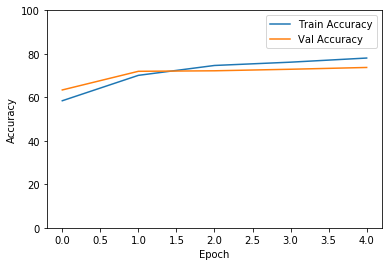

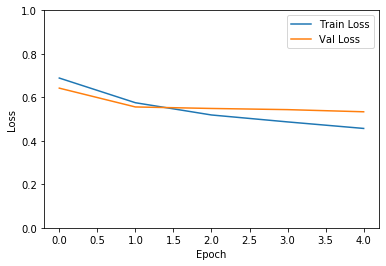

In [191]:
#GRU Model for word Embeddings of length 100
GRUModel100 = sentimentLSTM(vocabSize,word_index,50,learningRate,36,24)
hist = GRUModel100.fit(np.asarray(newtrainData24), np.asarray(trainLabels), epochs=5, batch_size=300, validation_data=(np.asarray(newtestData24), np.asarray(testLabels)))
plot_history(hist)

## <font color = "green">Best Model</font>

GRU has very little accuracy than the lstm and rnn in this. Given the complexity of GRU and LSTM when the accuracy is similar like above it is better that we use simpler vanilla RNN than the complex models in the real world applications when the accuracies of all the three of them are similar

In [200]:
from sklearn.metrics import recall_score,f1_score,precision_score
gru_predicted_y= bestGRUModel.predict_classes(np.array(newtestData24))
gru_recall_score=recall_score(np.asarray(testLabels), gru_predicted_y, average='binary')
gru_f1_score=f1_score(np.asarray(testLabels),gru_predicted_y,average='binary')
gru_precision_score=precision_score(np.asarray(testLabels),gru_predicted_y,average='binary')

print("For the Best GRU Model")
print("F1_Score = {}, Recall = {}, Precision = {}".format(gru_f1_score,gru_recall_score,gru_precision_score))

For the Best GRU Model
F1_Score = 0.7619639527656931, Recall = 0.706221198156682, Precision = 0.8272604588394062


In [201]:
lstm_predicted_y= bestLSTMModel.predict_classes(np.array(newtestData24))
lstm_recall_score=recall_score(np.asarray(testLabels), lstm_predicted_y, average='binary')
lstm_f1_score=f1_score(np.asarray(testLabels),lstm_predicted_y,average='binary')
lstm_precision_score=precision_score(np.asarray(testLabels),lstm_predicted_y,average='binary')

print("For the Best LSTM Model")
print("F1_Score = {}, Recall = {}, Precision = {}".format(lstm_f1_score,lstm_recall_score,lstm_precision_score))

For the Best LSTM Model
F1_Score = 0.7748068924539513, Recall = 0.7511520737327189, Precision = 0.8


In [202]:
rnn_predicted_y= bestRNNModel.predict_classes(np.array(newtestData24))
rnn_recall_score=recall_score(np.asarray(testLabels), rnn_predicted_y, average='binary')
rnn_f1_score=f1_score(np.asarray(testLabels),rnn_predicted_y,average='binary')
rnn_precision_score=precision_score(np.asarray(testLabels),rnn_predicted_y,average='binary')

print("For the Best RNN Model")
print("F1_Score = {}, Recall = {}, Precision = {}".format(rnn_f1_score,rnn_recall_score,rnn_precision_score))

For the Best RNN Model
F1_Score = 0.7597282273008029, Recall = 0.7085253456221198, Precision = 0.8189081225033289


### <font color = "green"> Analysis for F1 Score, Recall, Precision </font>
F1 score can be generally used when the data distribution of labels is uneven. But here the number of negative and positive training cases are of same ratio. So F1 score is of less value here. We observe that the F1 score and the Precision are almost same for the three models. Instead we observe that LSTM has a higher Recall than the other two. So it means it classifies a less false negatives than the other two. This is very important when the outcome of a review is very important. Suppose if you run a sentiment analysis on all the comments regarding a doctor. The review is of importance so we want as lesser false negatives as possible. In such cases we can use a LSTM.

## <font color = "green"> Overall Observation </font>

Best Model here GRU (By a little Margin)
As the word embedding size increases the accuracy increases
Highest accuracy on Test 75% approx